# Section 09
### Genetic algorithms and the Travelling Salesman Problem
In the following notebook the Travelling Salesman Problem will be addressed using the genetic algorithms approach.
In particular we will focus on two toy configurations:
- a set of 34 points ("cities") lying at equal distances on a circumference of radius 1;
- a set of 34 points uniformly distributed inside a square area of side 2.

In [1]:
import os

# Importing project specific variables and utilities,
# like the executables' paths
from ex09.data import *
from ex09.compute import *
from ex09.plot import *
from global_utils import *

# Importing multiprocess for parallel processing
import multiprocess as mp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("notebook", "whitegrid", rc={"figure.dpi": 150})

SECTION = "09"

# Whether to use cached data. The computation may take some time.
USE_CACHED = True


# Maximum number of processes for parallel execution
PROCESSES = max(os.cpu_count() - 1, 1)


### Searching for the best individual

The genetic process follows the standard loop:
1. generation of the initial population;
1. computation of the each individual's fitness;
1. selection of parents;
1. crossover of parents to generate new individuals;
1. mutation of the new individuals;
1. repeat from 2. for a given number of times.

**Population**

In this work the "individual" is implemented as a list of indices: each index points to the coordinates of a city. The first index is fixed to reduce the degrees of freedom.

**Fitness**

The inverse of the total travelling distance (using $L^{(2)}$ as distance between points) will be used as fitness.

**Selection**

Parents are sampled from the population using a weighted discrete distribution, where each individual's weight is its fitness.

**Crossover**

Different crossover methods will be compared on the task of finding the shortest path. The following algorithms will be used:
- "ex": the parents are cut at a random point and the elements after that point are ordered as they appear in the other parent, as explained in the exercise's instructions;
- "exmod": works like the previous procedure but the slices which will be reordered may be inside the individual and not extend till its end; moreover they do not necessarily start at the same position (although they have the same length);
- "my2": the algorithm selects a slice of defined length from each parent and swaps them, keeping the remaining elements in the ordered they appeared in before;
- "fusion": throws a weighted coin to execute either "my2" (if true) or "exmod";
- "dummy": clones the parents; used as a baseline.

**Mutation**

Each individual may be subject to a mutation chosen uniformly at random between:
- reflection: a slice of the individual has its elements put in the inverse order;
- ranges swap: two non-overlapping, same-length slices of the individual are swapped;
- ranges rotation: two contiguous slices of the individual are swapped.

The genetic process implementation here keeps track of the best individual across different generations and returns it as the best result.


In [2]:
# Generating coordinates on a circle
CIRCLE_PATH = DATA_PATH / f"{TSP.CIRCLE.value}.csv"
generate_circle_coordinates(CIRCLE_PATH, radius=1.0)
# Generating coordinates inside a square
SQUARE_PATH = DATA_PATH / f"{TSP.SQUARE.value}.csv"
generate_square_coordinates(SQUARE_PATH, seed=1, side=2.0)

SEEDS = list(range(4))

# Defining all the combinations of crossover algorithms (algo) and problem (tsp: circle or square)
configs = [{"coords": coordinates_path,
            "tsp": tsp,
            "algo": algo,
            "seed": seed}
           for coordinates_path, tsp in zip([CIRCLE_PATH, SQUARE_PATH], [TSP.CIRCLE, TSP.SQUARE])
           for algo in list(Algo)
           for seed in SEEDS]

# Running the genetic processes in parallel. Check the documentation of "run_ga".
with mp.Pool(PROCESSES) as pool:
    res = list(pool.imap(
        lambda args: run_ga(input=args["coords"], n_iter=2_000, pop_size=100_000, mut_rate=0.05, fusion_p=0.8, tsp=args["tsp"], algo=args["algo"], p_line=args["seed"], use_cached=USE_CACHED), configs))


cross_tsp: exmod[================================================================================] :36s<00m:00s] best fitness: 0.105430
cross_tsp: exmod[================================================================================] :54s<00m:00s] best fitness: 0.124351
cross_tsp: exmod[================================================================================] :56s<00m:00s] best fitness: 0.116288
cross_tsp: ex[================================================================================] :20s<00m:00s] best fitness: 0.124222266
cross_tsp: ex[================================================================================] :22s<00m:00s] best fitness: 0.122910366
cross_tsp: ex[================================================================================] :35s<00m:00s] best fitness: 0.117771266
cross_tsp: ex[================================================================================] :36s<00m:00s] best fitness: 0.164211866
cross_tsp: exmod[===============================

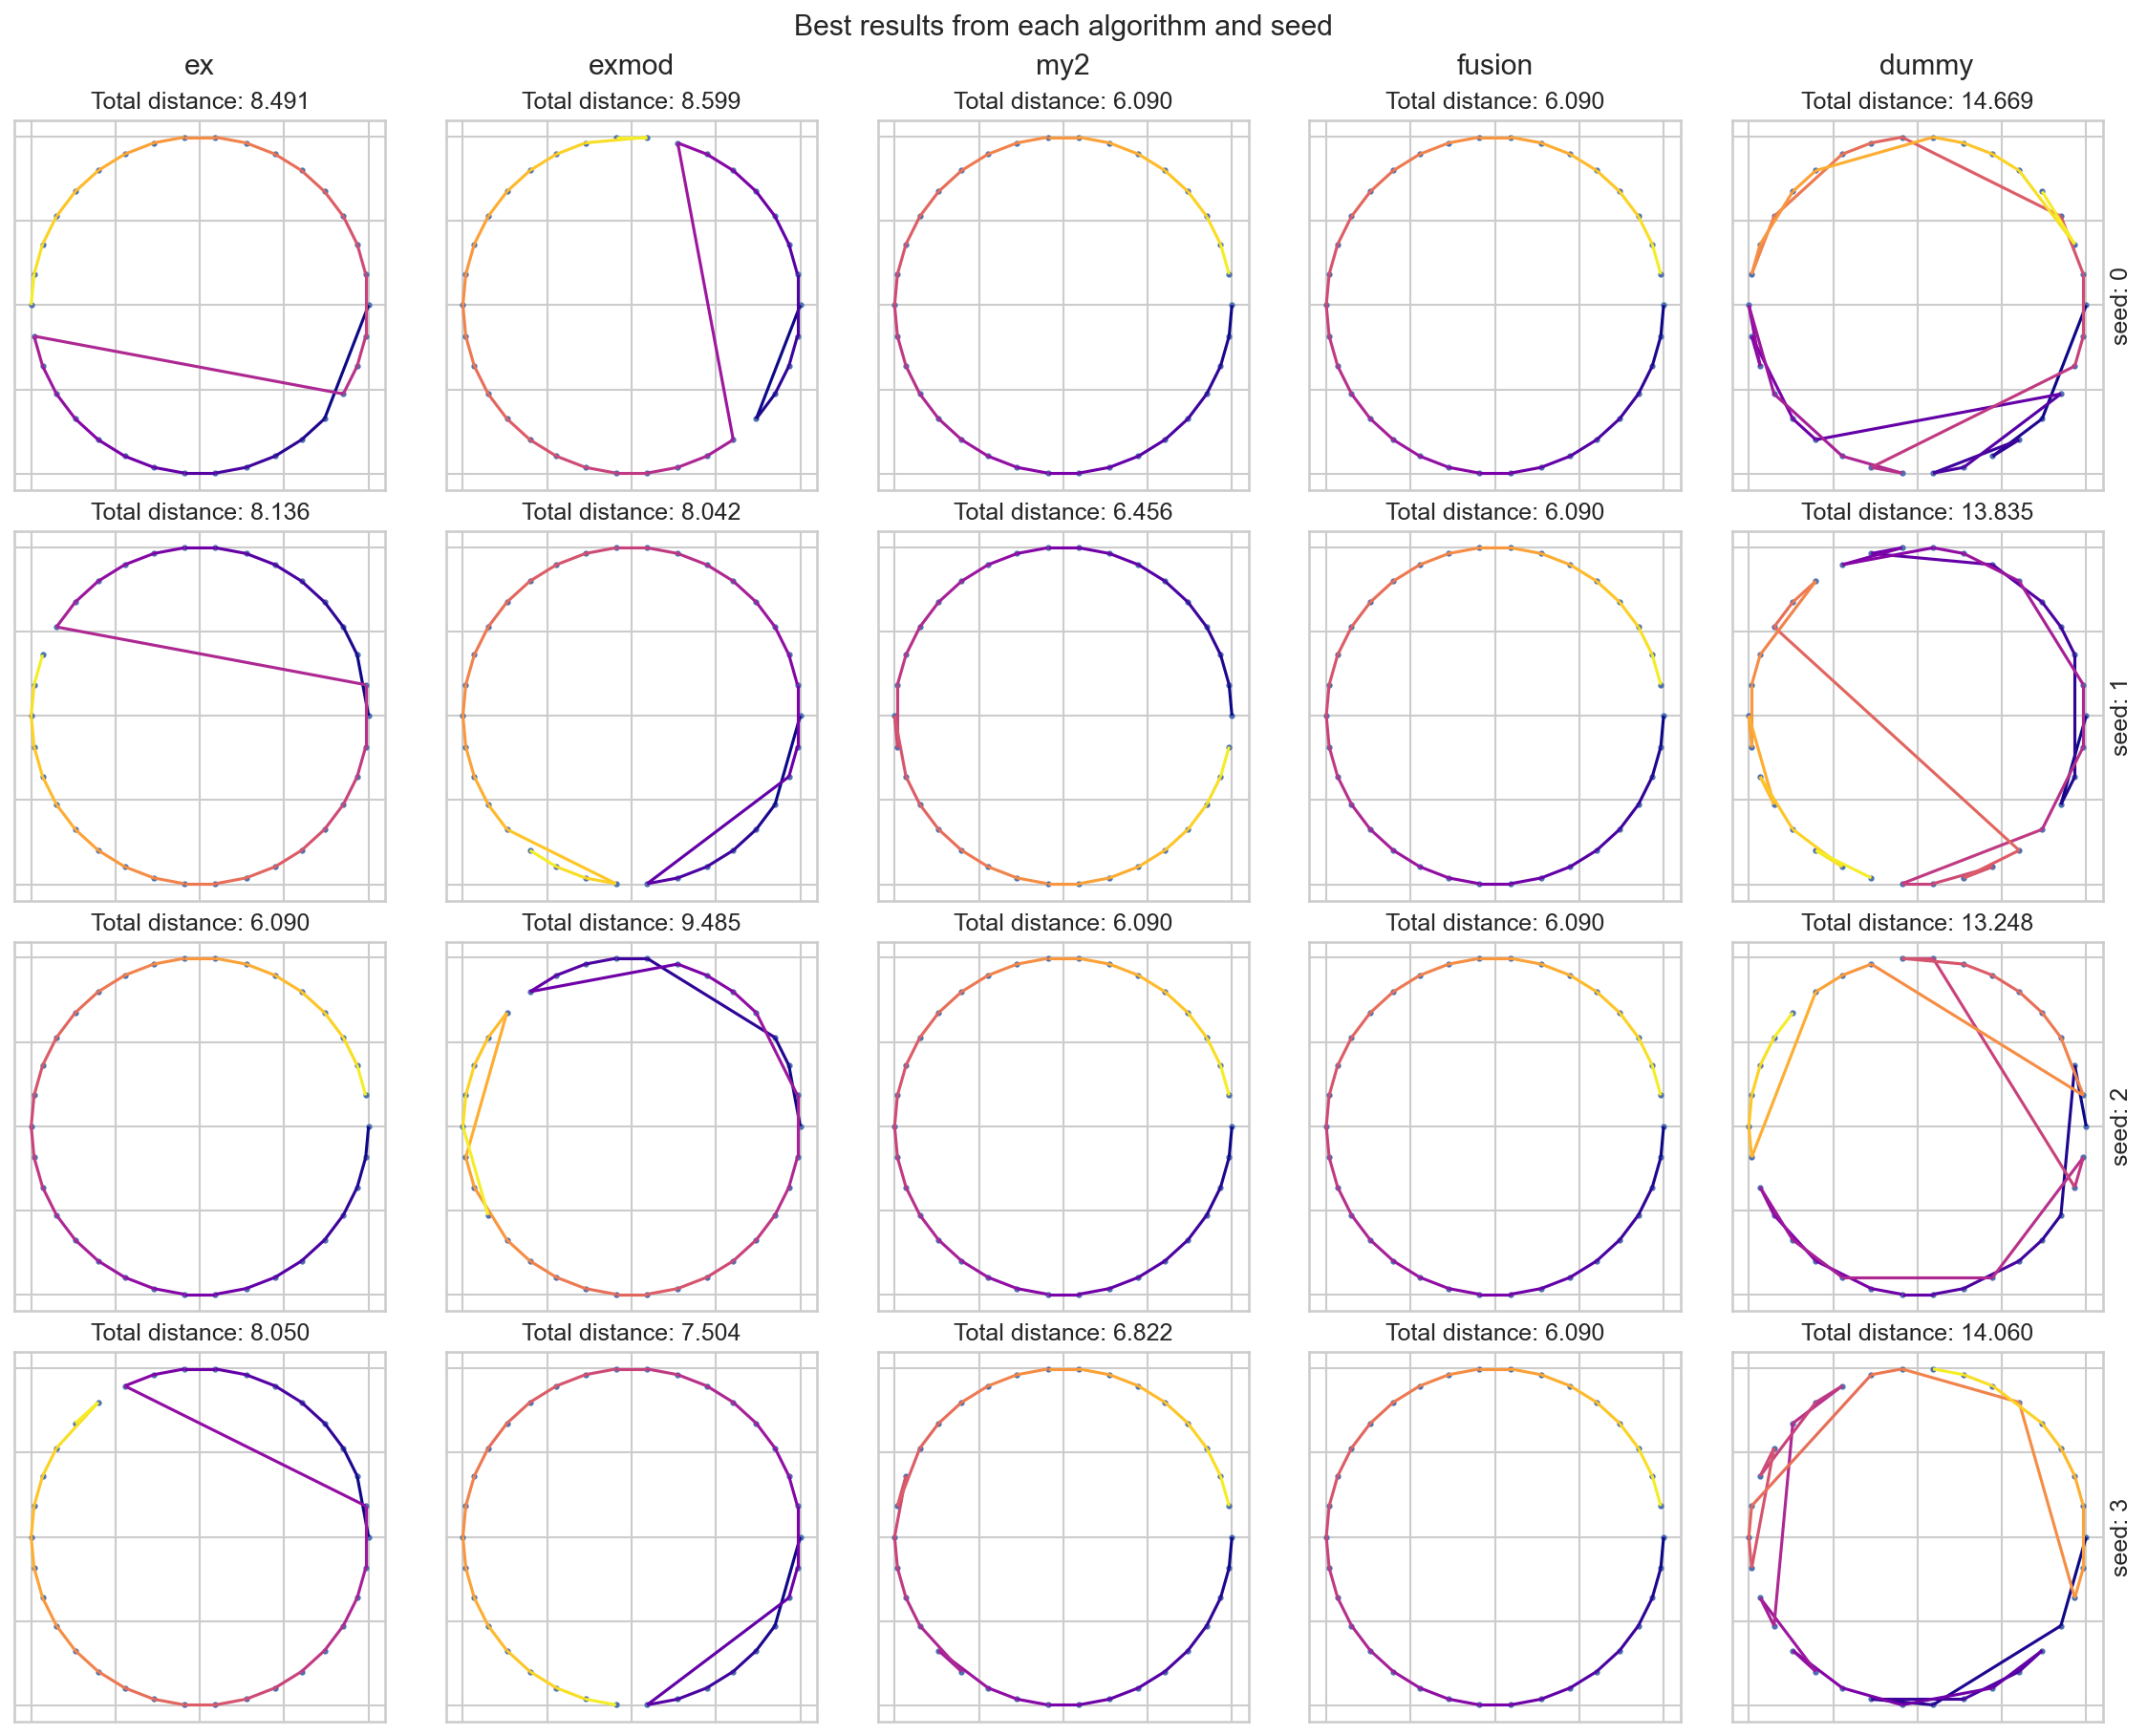

In [3]:
# Displaying the results of the circle TSP side-by-side for comparison
_ = plot_panel(TSP.CIRCLE, CIRCLE_PATH, SEEDS)


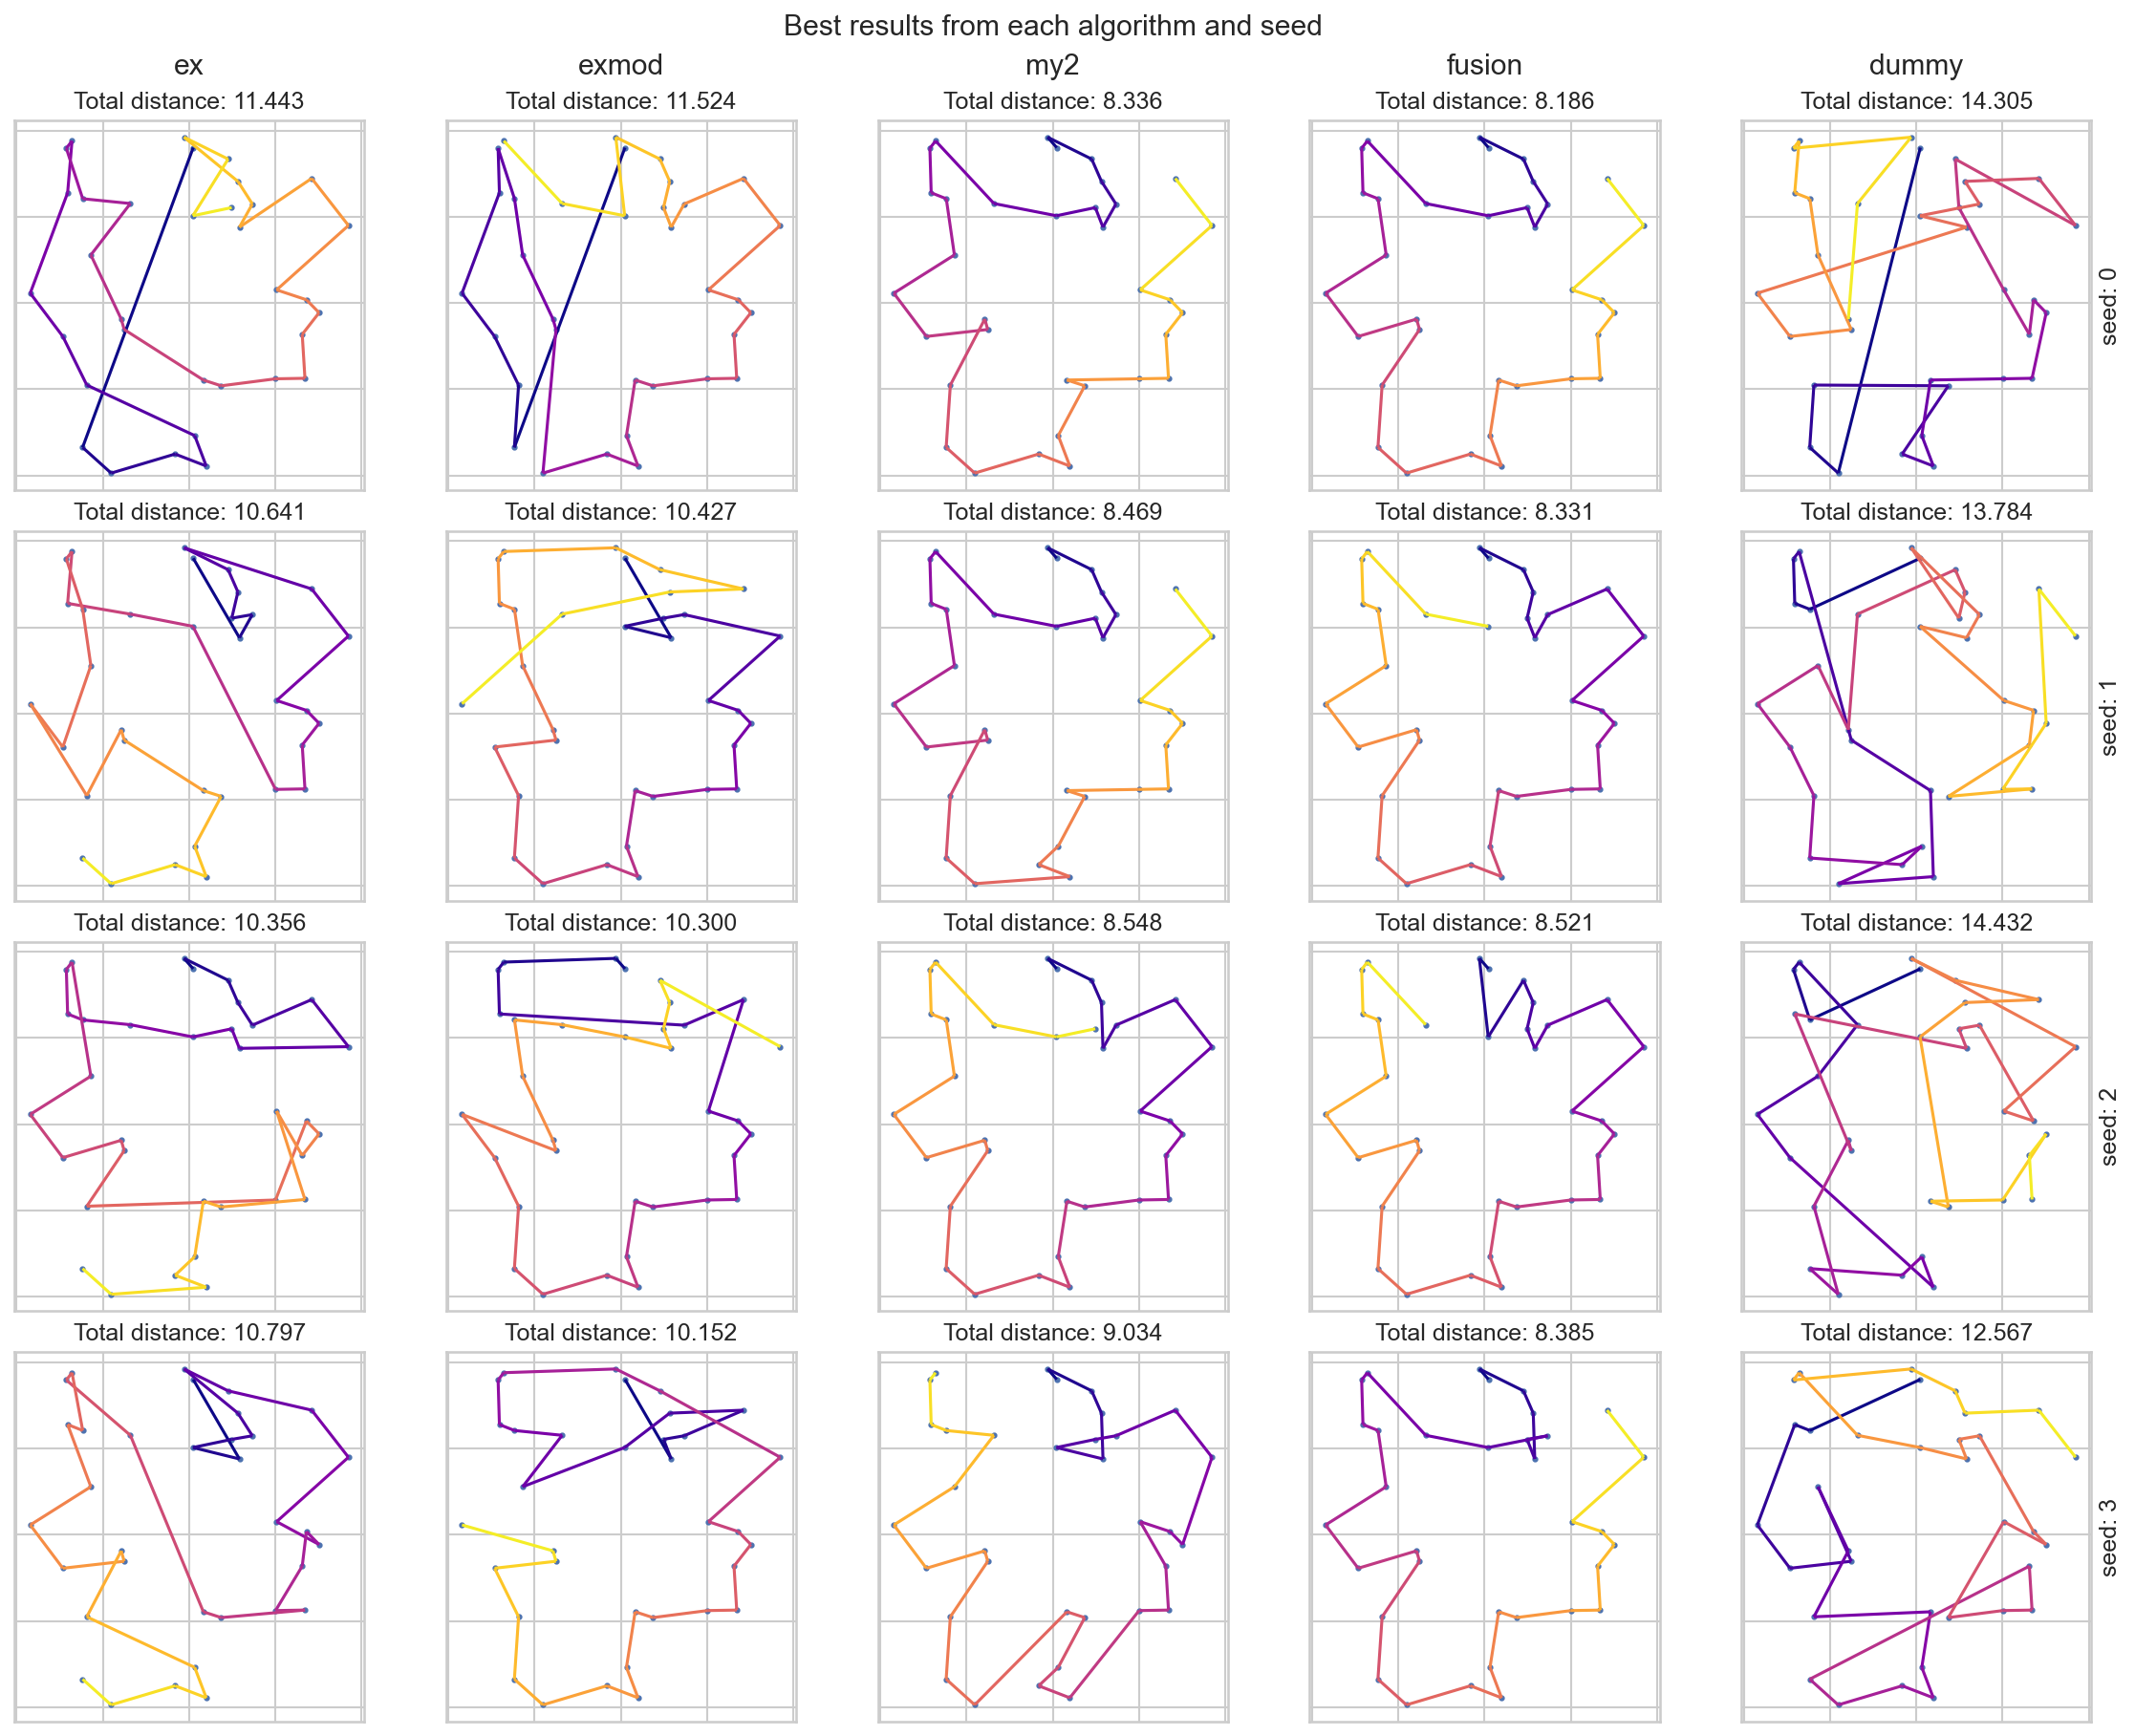

In [4]:
# Displaying the results of the circle TSP side-by-side for comparison
_ = plot_panel(TSP.SQUARE, SQUARE_PATH, SEEDS)


The plots above show that the "fusion" approach finds the best individual overall for both TSPs. It was found that this is true in most of the cases (especially for the "circle" problem), although it depends on the chosen "fusion_p" hyperparameter.

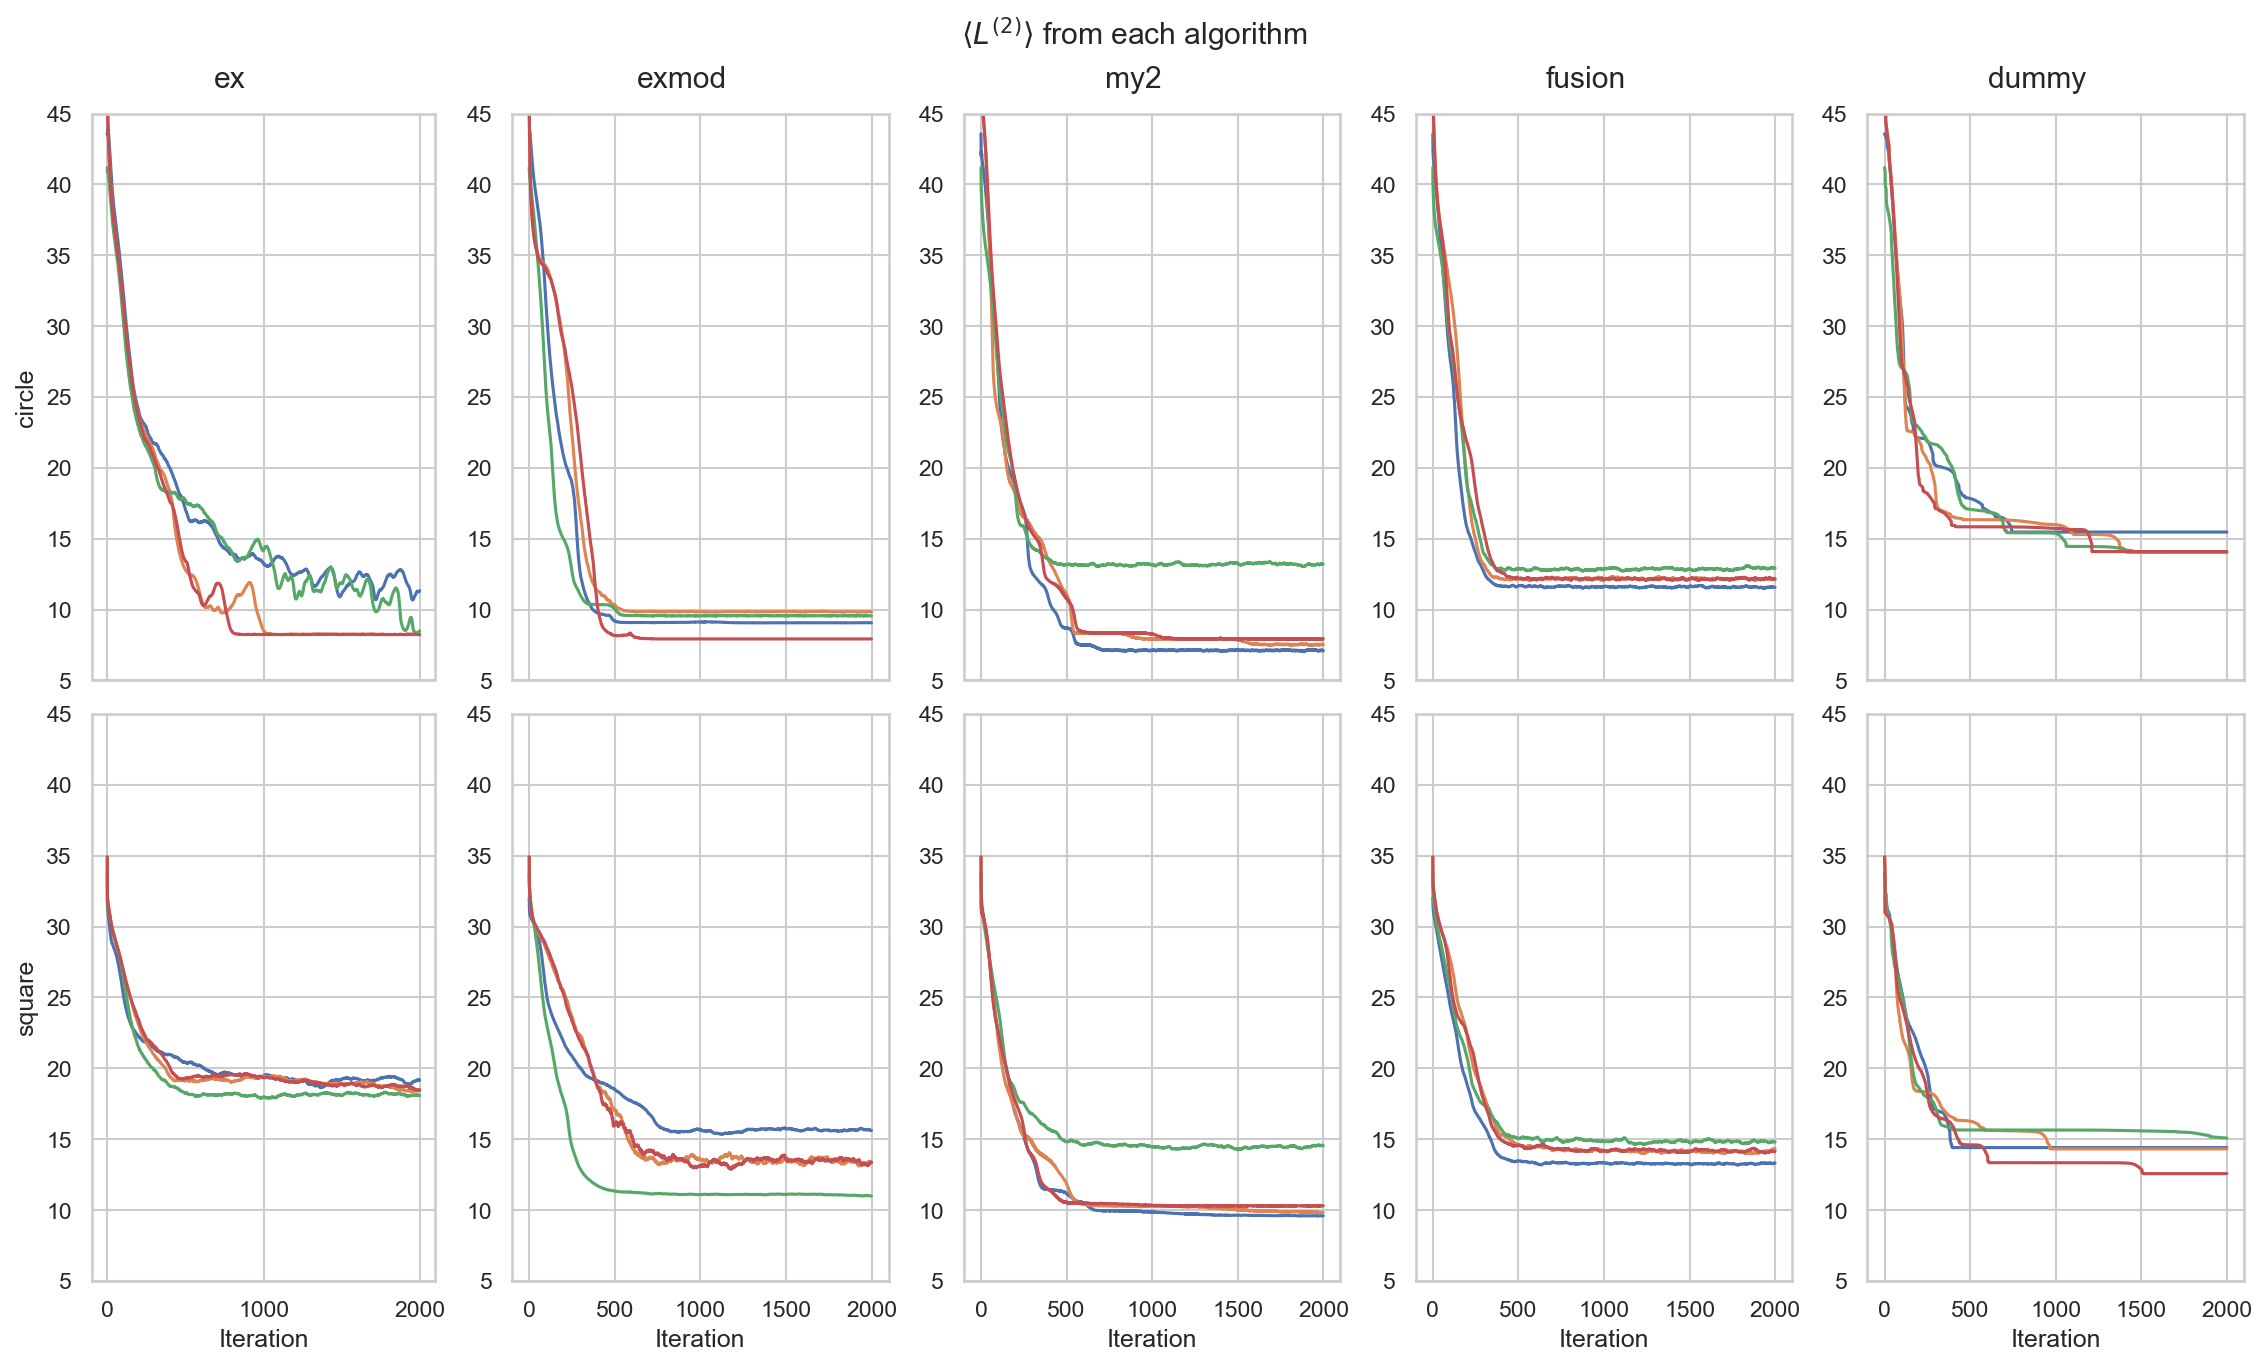

In [5]:
# Displaying <L2> per iteration side-by-side for comparison

# Preparing the matplotlib figure
fig = plt.figure(figsize=(len(Algo)*3, len(TSP)*3), constrained_layout=True)
subfigs = fig.subfigures(1, len(Algo))
fig.suptitle(r"$\langle L^{(2)} \rangle$ from each algorithm")

for algo, subfig in zip(Algo, subfigs):
    # Preparing the figure's panels, one for each algorithm
    subfig.suptitle(f"{algo.value}")
    axes = subfig.subplots(2, 1, sharex=True)
    for tsp, ax in zip(TSP, axes):
        for seed in SEEDS:
            # Loading and plotting the data
            l2s = distances_per_iter_from(tsp, algo, p_line=seed)
            l2s.plot(ax=ax, legend=False)
            ax.set_xlabel("Iteration")
            ax.set_ylim((5, 45))
for tsp, ax in zip(TSP, subfigs[0].axes):
    ax.set_ylabel(f"{tsp.value}")


The plots above show that the algorithms have different statistical behaviour:
- "my2" and "fusion" seem to converge faster to a stable population (in terms of fitness, at least);
- "ex", "exmod" and "my2" reach very different results depending on the random seed, while "fusion" seems much more stable;
- despite not having the best statistics "fusion" usually reaches the best results. This may mean that it is able to optimize while retaining a reserve of entropy.